# **Identifying Pneumonia Using Deep Learning**
## Yung Han Jeong, Dan Valenzuela

***



In [35]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
import torch
import torch.nn as nn #neural network
import torchvision as tv
import torchvision.transforms as TF
import torch.optim as optim # optimizer
import numpy as np

module_path = os.path.abspath(os.path.join( 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules import dataloading as dl
from modules import VizAx as va
from modules import sequential_linear as sl1_model 
from modules import sequential_linear2 as sl2_model 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, confusion_matrix, plot_confusion_matrix



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Overview** <a id="Overview"></a>

This project aims to develop a deep learning model to accurately identify cases of pneumonia using x-ray images of patients' lungs. Doctors both overdiagnose and underdiagnose pneumonia, both of which can have fatal consequences. Using a neural net with one input layer, one ReLU-activated hidden layer, and one sigmoid-activated output layer, all densely connected, this project was able to achieve an F1 score of 0.873. Given this F1 score, we believe this model can be best used in instances where doctors are unsure of the diagnosis and may want to use computer methods to identify pneumonia patterns invisible to human perception.


[**1. Business Problem**](#Business-Problem)

[**2. Data Understanding**](#Data-Understanding)

[**3. Data Preparation**](#Data-Preparation)

[**4. Modeling**](#Modeling)

[**5. Evaluation**](#Evaluation)

[**6. Conclusion and Next Steps**](#Conclusion)

[**7. Endnotes**](#Endnotes)
***

## **Business Problem** <a id="Business-Problem"></a>
[*↑ Back to overview*](#Overview)

Doctors both overdiagnose and underdiagnose pneumonia, both of which have can have fatal consequences. <a id="FN-1-SRC"></a>[<sup>1</sup>](#FN-1) A failure to diagnose pneumonia (and generally underdiagnosing in a population) can lead to potentially fatal complications as the illness develops. And diagnosing pneumonia when it doesn't exist (and generally overdiagnosing in a population) can increase the prescription of antibiotics, which can lead to the development of antibiotic-resistant pathogens. <a id="FN-2-SRC"></a> [<sup>2</sup>](#FN-2)

Part of this problem can be due to the fact that examination of chest x-rays by doctors are limited by the structures and bias of human perception. Other researchers have found that deep-learning models have helped doctors interpret chest x-rays for signs of pneumonia. <a id="FN-3-SRC"></a> [<sup>3</sup>](#FN-3)

This project aims to contribute to current efforts in developing machine learning-assisted pneumonia diagnoses by creating a deep-learning model that classifies chest x-ray images as having pneumonia or not having pneumonia. To that end, first we give an overview of the images used to train the deep-learning model.

[*↑ Back to overview*](#Overview)
***

## **Data Understanding** <a id="Data-Understanding"></a>
[*↑ Back to overview*](#Overview)

### Characteristics Overview

We obtained a repository of chest x-ray images from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) which contains 5,856 chest x-ray images. 

In [2]:
index_df = pd.read_csv('data/image_index_dtl.csv')
index_df.shape[0]

5856

Of these images, approximately 4,200 of them are images of lungs with viral or bacterial pneumonia, and the other 1,600 do not have pneumonia. One potential challenge with the images of pneumonia is the fact that bacterial and viral pneumonia manifest themselves in different ways. Bacterial pneuomnia shows mass in the lungs in concentrated areas whereas viral pneumonia shows increased mass throughout the lungs.

In [3]:
index_df.condition.value_counts()

1    4273
0    1583
Name: condition, dtype: int64

<center><img src='images/CXRimages.png'></center>

Further, each of the images come in varying sizes and color. Generally speaking the images are about 1.5 times wider than they are high. But images can range from approximately 127x384 pixels to 2583x2916 pixels with a large portion of the color images being less than 800 pixels high or 1300 pixels wide.

/Users/danielvalenzuela/Documents/Flatiron/Repositories/phase4/Pneumonia-ID/src/modules/VizAx.py:21: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  Title = "Dimensions of Images Colored by Image Type"


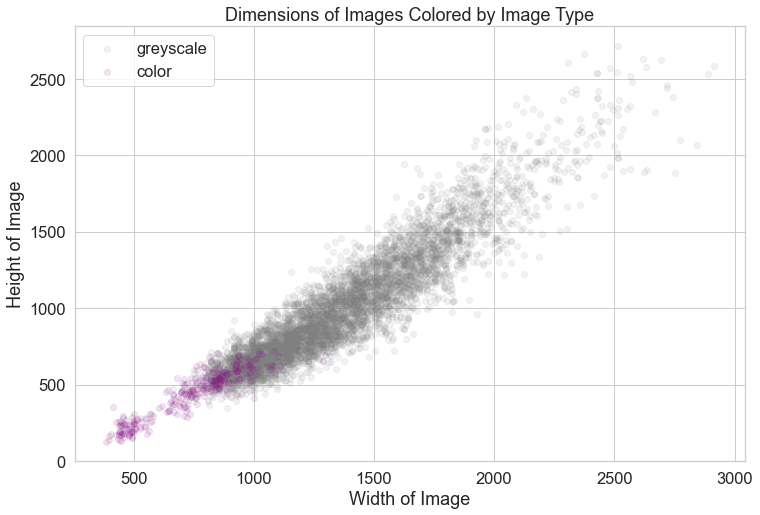

In [4]:
va.channelScatter(index_df)

The variability of these images are dealt with in data preparation. Generally, the variability across the images requires that some transformations be done to the images to help with standardization.

For example, the image below with the smallest width in the dataset is in color and much wider than it is high. Such an image may require a crop and transformation into greyscale. The image below with the largest width among the dataset, on the otherhand, is already in greyscale but will likely require a re-sizing to be consistent with the dataset that is largely smaller than this image.

#### Image with Smallest Width

In [5]:
smallest_w = index_df[index_df['width']==index_df.width.min()]
smallest_w

,img,data_set,condition,image_tensor,channels,height,width,data_set_name
4306,..\..\data\extracted\chest_xray\train\PNEUMONI...,1,1,"[3, 127, 384]",3,127,384,train


<center><img src='images/person407_virus_811.jpeg'></center>

#### Image with Largest Width

In [6]:
biggest_w = index_df[index_df['width']==index_df.width.max()]
biggest_w

,img,data_set,condition,image_tensor,channels,height,width,data_set_name
1858,..\..\data\extracted\chest_xray\train\NORMAL\N...,1,0,"[1, 2583, 2916]",1,2583,2916,train


<center><img src='images/NORMAL2-IM-1257-0001.jpeg'></center>

### Test-Train Split Overview

Another benefit of this Kaggle dataset is that it has already been split into test, train, and validation subsets. Below is an overview of the images' height and width categorized by whether they belong to one of the test-train subsets. As one can see both in the figure and the tables, each subset generally has similar distributions in terms of height and width of the images.

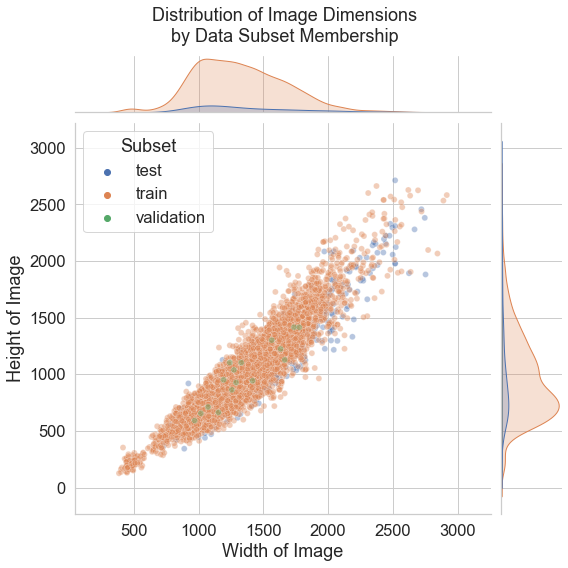

In [7]:
va.subsetsJoint(index_df)

In [8]:
index_df.groupby("data_set_name").height.describe()

,count,mean,std,min,25%,50%,75%,max
data_set_name,,,,,,,,
test,624.0,991.714744,421.608963,344.0,688.0,870.5,1183.25,2713.0
train,5216.0,968.074770,378.855691,127.0,688.0,888.0,1187.75,2663.0
validation,16.0,1002.937500,262.954868,592.0,826.0,996.0,1152.25,1416.0


In [9]:
index_df.groupby("data_set_name").width.describe()

,count,mean,std,min,25%,50%,75%,max
data_set_name,,,,,,,,
test,624.0,1388.128205,423.573061,728.0,1072.0,1265.0,1640.0,2752.0
train,5216.0,1320.610813,355.298743,384.0,1056.0,1284.0,1552.0,2916.0
validation,16.0,1348.250000,256.771624,968.0,1182.0,1280.0,1581.0,1776.0


However, it is noteable that only the training subset has color images. The table below shows that the train subset is the only subset with color images and will need to be dealt with accordingly so that the model can generalize to the test and validation subsets.

In [10]:
index_df.groupby("data_set_name").channels.describe()

,count,mean,std,min,25%,50%,75%,max
data_set_name,,,,,,,,
test,624.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
train,5216.0,1.108512,0.453088,1.0,1.0,1.0,1.0,3.0
validation,16.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


[*↑ Back to overview*](#Overview)
***

## **Data Preparation** <a id="Data-Preparation"></a>
[*↑ Back to overview*](#Overview)

As previewed in [Data Understanding](#Data-Understanding), there are various characteristics of this dataset that require transformation in order to feed them into a deep learning model. Below is a function which standardizes the images which are fed into the model.



In [11]:
def preprocess_image_flat(path_list, img_h=120, img_w=120):
    outlist = [] #intialize blank list
    for path in path_list: #for all file path
        resizer = TF.Resize((img_h, img_w)) #define resizer per new_h and new_w
        im = tv.io.read_image(path).type(torch.float) #read image as pytorch float tensor
        im = resizer(im) #resize image
        if im.shape[0] != 1:
            im = TF.functional.rgb_to_grayscale(im)
        normalizer = TF.Normalize(im.mean(), im.std()) #initialize normalizer
        im = normalizer(im) # return normalized pytorch float tensor
        im = torch.flatten(im)
        outlist.append(im)
    return torch.stack(outlist) # return all tensors in a stacked tensor

First, the model resizes the all images to 120x120. We chose this size for two reasons: (1) it was smaller than all the other images in the dataset and (2) the smaller size allows for quicker training. 

Second, the model takes any non-grayscale image and converts it to grayscale to be consistent with the rest of the dataset. At the same time, the image pixels are normalized in order to account for the fact that each x-ray might be exposed different leading to differences in overall levels of activation of each pixel. 

Finally, the image pixels are flattened into a 1xN tensor so that it can be fed into the model. This is done for all the images in a certain path list. In the case of the model, this will be the path list for each subset.

[*↑ Back to overview*](#Overview)
***

## **Modeling** <a id="Modeling"></a>
[*↑ Back to overview*](#Overview)

The deep learning model presented here went through three iterations implemented through Pytorch. The basic model as shown below contains one input layer, one hidden layer, and one output layer, all densely connected.

The input layer of the flattened tensor described above is fed to the hidden layer which reduces the number of nodes to 320, each of which is activated using ReLU. Those 320 nodes are then fed into the output layer which is one node activated using sigmoid to produce a probability between 0 and 1 that the image shows a patient with pneumonia. Lastly, this model was optimized using ADAM and a binary cross entropy loss function. 

One important thing to note with the output layer is that given our datasets, it would difficult to compare predictions to actual values in our test data set to test for accuracy, recall, etc. In order to do so, we establish a threshhold on the output layer to transform it from a continous distribution to discrete values of 1 or 0. Because we expect the neural net to overfit to the large numbers of images with pneumonia, we weighted all probabilities below or equal to a threshold of 0.9 with 0 while making those above 0.9 equal to 1. This results in predictions of pneumonia only when the model provides a probability in its output layer.

In [12]:
class linear_prototype(nn.Module):
    def __init__(self, img_h, img_w):
        super().__init__()
        #define sizes here
        self.h = img_h
        self.w = img_w
        self.longshape = img_h*img_w
        self.linear1 = nn.Linear(self.longshape, 320) #input is longtensor of h*W, reduce to 320
        self.relu1 = nn.ReLU() #activate first layer
        self.linear2 = nn.Linear(320, 1) #reduce to 1
        self.termn_act = nn.Sigmoid() #terminal layer
    
    def forward(self, x):
        # preprocess the input image
        #============ Layer1==============#
        x = self.linear1(x)
        x = self.relu1(x)
        #============Layer2==============#
        x = self.linear2(x)
        #x = self.softmax(x)
        x = self.termn_act(x)
        return x

Given this base model, three iterations were created. 

**1. Simple Linear**
- The base model with an optimizer using a small L2 penalty.

**2. Simple Linear with Hard Decay**
- The base model with an optimizer using a larger L2 penalty.

**3. Simple Linear with Relu Activation**
- The base model with additional ReLU activation layer after the softmax activation.

All the training and testing of all three modeling can be found in the [Model Test notebook](notebooks/pneumonia_model_test.ipynb). Out of all the models the second model performed the best, the results of which are below.

### Image Preprocessing

In [13]:
# set image reduction size
img_reduce_h=120
img_reduce_w=120

In [14]:
index_df = pd.read_csv("data/image_index.csv", index_col=0)
index_df.head()

,img,data_set,condition
0,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
1,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
2,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
3,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
4,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0


In [21]:
# update path to right directory
index_df["newpath"] = index_df.img.apply(lambda x: x[6:])
## run if on mac
#index_df['newpath'] = [path.replace("\\", "/") for path in index_df['newpath']]

In [22]:
val_df = index_df[index_df.data_set==0]
y_true = val_df["condition"].values
img_paths = val_df.newpath.values

In [24]:
input_tensor = sl1_model.preprocess_image_flat(img_paths, img_reduce_h, img_reduce_w)

### Model 2 of 3

In [31]:
threshold = 0.9
if threshold >= 1 or threshold <=0:
    print("ERROR please set threshold to between 0-1, excluding 0 or 1")

In [29]:
simple_linear_hard_decay = sl1_model.linear_prototype(img_reduce_h, img_reduce_w)
simple_linear_hard_decay.load_state_dict(torch.load("models/pneumonia_simple_decay_02.pt", map_location=torch.device('cpu')))
simple_linear_hard_decay.eval()

linear_prototype(
  (linear1): Linear(in_features=14400, out_features=320, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=320, out_features=1, bias=True)
  (termn_act): Sigmoid()
)

In [32]:
y_pred_sh = simple_linear_hard_decay(input_tensor)
y_pred_sh.flatten().detach().numpy()
y_pred_sh = np.array([1 if ans >= threshold else 0 for ans in y_pred_sh])

In [33]:
f1 = f1_score(y_true, y_pred_sh)
recall = recall_score(y_true, y_pred_sh)

print("Simple Model with Large Decay F1:", f1)
print("Simple Model with Large Decay Recall:", recall)

Simple Model with Large Decay F1: 0.8733087330873308
Simple Model with Large Decay Recall: 0.9102564102564102


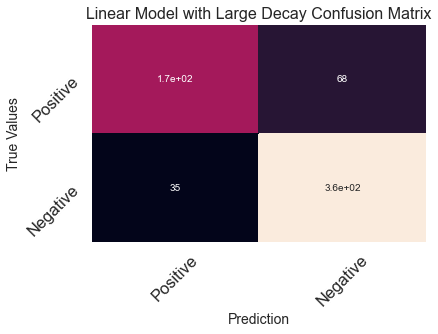

In [36]:
simple_large_cf = confusion_matrix(y_true, y_pred_sh)
sns.heatmap(simple_large_cf, annot=True, cbar=False)
plt.ylabel("True Values", size=14)
plt.yticks([0.5, 1.5], ["Positive", "Negative"], rotation=45)
plt.xlabel("Prediction", size=14)
plt.xticks([0.5, 1.5], ["Positive", "Negative"], rotation=45)
plt.title("Linear Model with Large Decay Confusion Matrix", size=16)
plt.show()

This model achieves an F1 score of 0.873 and a recall of 0.910 on a testing data set of about 625 images. Considering that deep learning models generally tend to overfit to the data, achieving a recall score of less than 1 shows that the regularization and the threshold setting helps with the overfitting. This can be verified with a validation data set.

[*↑ Back to overview*](#Overview)
***

## **Evaluation**<a id="Evaluation"></a>
[*↑ Back to overview*](#Overview)


The validation data set is a set of 16 images containing equal amounts of pneumonia and non-pneumonia images. Ostensibly the model developed here will likely provide false positives. However, the results below show that the model manages to correctly identify all 16 images. This implies that the efforts we took to address potential overfitting have been effective.

In [37]:
val_df = index_df[index_df.data_set==2]
y_true = val_df["condition"].values
img_paths = val_df.newpath.values

In [39]:
input_tensor = sl1_model.preprocess_image_flat(img_paths, img_reduce_h, img_reduce_w)

In [40]:
simple_linear_hard_decay = sl1_model.linear_prototype(img_reduce_h, img_reduce_w)
simple_linear_hard_decay.load_state_dict(torch.load("models/pneumonia_simple_decay_02.pt", map_location=torch.device('cpu')))
simple_linear_hard_decay.eval()

linear_prototype(
  (linear1): Linear(in_features=14400, out_features=320, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=320, out_features=1, bias=True)
  (termn_act): Sigmoid()
)

In [41]:
y_pred_sh = simple_linear_hard_decay(input_tensor)
y_pred_sh.flatten().detach().numpy()
y_pred_sh = np.array([1 if ans >= threshold else 0 for ans in y_pred_sh])

In [42]:
f1 = f1_score(y_true, y_pred_sh)
recall = recall_score(y_true, y_pred_sh)

print("Simple Model with Large Decay F1:", f1)
print("Simple Model with Large Decay Recall:", recall)

Simple Model with Large Decay F1: 1.0
Simple Model with Large Decay Recall: 1.0


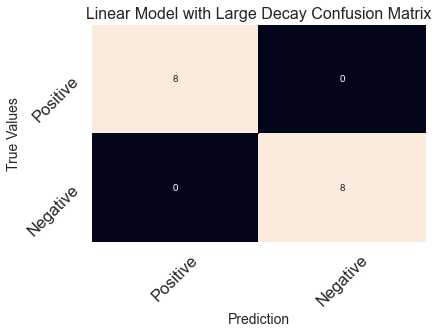

In [43]:
simple_large_cf = confusion_matrix(y_true, y_pred_sh)
sns.heatmap(simple_large_cf, annot=True, cbar=False)
plt.ylabel("True Values", size=14)
plt.yticks([0.5, 1.5], ["Positive", "Negative"], rotation=45)
plt.xlabel("Prediction", size=14)
plt.xticks([0.5, 1.5], ["Positive", "Negative"], rotation=45)
plt.title("Linear Model with Large Decay Confusion Matrix", size=16)
plt.show()

[*↑ Back to overview*](#Overview)
***

## **Conclusion and Next Steps**<a id="Conclusion"></a>
[*↑ Back to overview*](#Overview)

There are three possible impacts we can foresee for this model:

**1. Doctors**
- In cases where doctors can see evidence of both pneumonia and non-pneumonia, this model can be utilized as a supplemental tool to provide additional insight.

**2. Labs and Specialists**
- The tool can help labs and specialists performing x-ray imaging with their own x-ray analysis.

**3. Patients**
- Such a model may assist in providing positive outcomes for patietns in a quick and cost-effective manner.

However, the model can still be improved throught the following proposed next steps:

**1. Class Imbalance**
- Since our training dataset has a higher prevalance of pneumonia than the general population, the training can be assisted throguh upsampling of the minority class in the data.

**2. Less Compression**
- We can increase the amount of information the model can use by increasing the amount of processing power available to the model, and hopefully increase performance.

**3. Complexity**
- We can introduce additional layers to the model and reduce the amount of processing done to the images.




[*↑ Back to overview*](#Overview)
***

## **Endnotes**<a id="Endnotes"></a>
[*↑ Back to overview*](#Overview)

<a id="FN-1"></a> [1:](#FN-1-SRC) https://jamanetwork.com/journals/jamainternalmedicine/article-abstract/485032

<a id="FN-2"></a> [2:](#FN-2-SRC) https://www.sciencedirect.com/science/article/pii/S1201971219303534

<a id="FN-3"></a> [3:](#FN-3-SRC) https://med.stanford.edu/news/all-news/2017/11/algorithm-can-diagnose-pneumonia-better-than-radiologists.html

[*↑ Back to overview*](#Overview)
***